> __Purpose:__ Implement a linkage attack, an initial and final one, on the newly saved data from the latest sims. Significant alterations were required to extract the data from the latest sims save files.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pickle
import random
import os
import h5py
import copy
import statistics

import seaborn as sns

#from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.naive_bayes import GaussianNB
#from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier

import re

#import warnings
#warnings.filterwarnings("ignore")

from utils import *

random.seed(a=1)

In [2]:
final_update = 16

In [3]:
SAVING = False

#raise ValueError("MAKE SURE SAVING IS WHAT YOU WANT IT TO BE!")

## Load Data

In [4]:
NUM_PLOTTED_CONDITIONS = 6
NUM_PLOTTED_CONDITIONS_WITH_GLOBAL = 10
NUM_CLIENTS = 14
NUM_FOLDS = 5

results_path = r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\PythonVersion\PythonSimsRevamp\results'
current_directory = r'\FinalSimRes'
base_path = results_path + current_directory

'''
# CROSS
10-05_14-23_NOFL_Cross
10-05_14-32_PFAFO_Cross5
10-05_14-48_FEDAVG_Cross5
10-05_15-08_FEDAVG_Cross1
10-05_15-14_PFAFO_Cross1

# INTRA
10-05_13-44_NOFL_Intra
10-05_13-46_FEDAVG_Intra5
10-05_13-55_FEDAVG_Intra1
10-05_14-10_PFAFO_Intra1
10-05_14-13_PFAFO_Intra5
'''

# CROSS
cpfa_model_dict = load_model_logs(base_path+r'\10-05_14-32_PFAFO_Cross5', 'GDLS_PFAFO_KFold')
cfa_model_dict = load_model_logs(base_path+r'\10-05_14-48_FEDAVG_Cross5', 'GDLS_FEDAVG_KFold')
cnofl_model_dict = load_model_logs(base_path+r'\10-05_14-23_NOFL_Cross', 'FULLSCIPYMIN_NOFL_KFold')
# INTRA
ipfa_model_dict = load_model_logs(base_path+r'\10-05_14-13_PFAFO_Intra5', 'GDLS_PFAFO_KFold')
ifa_model_dict = load_model_logs(base_path+r'\10-05_13-46_FEDAVG_Intra5', 'GDLS_FEDAVG_KFold')
inofl_model_dict = load_model_logs(base_path+r'\10-05_13-44_NOFL_Intra', 'FULLSCIPYMIN_NOFL_KFold')


In [5]:
for key in cpfa_model_dict.keys():
    print(len(cpfa_model_dict[key]))

1
105
105
114
104
1
106
103
104
106
101
104
105
105
251
102
101
111
106
106
98
1
1
105
113
115
116
101
88
251
110
110
108
113
95
92
110
111
1
1
105
97
103
108
251
100
101
103
115
109
122
108
105
109
89
1
1
107
94
251
109
98
107
93
114
100
119
103
100
115
112
92
1
1
251
102
1
1
113
103
107
102
96
101
102
93
105
111
127
251
95
106
114
1
1
103
107
113
108
99
99
93
110
115
251


In [6]:
for key in cnofl_model_dict.keys():
    print(len(cnofl_model_dict[key]))

1
13
13
13
13
1
13
13
13
13
13
13
13
13
13
13
13
13
13
13
1
1
13
13
13
13
13
13
13
13
13
13
13
13
13
13
1
1
13
13
13
13
13
13
13
13
13
13
13
13
13
13
1
1
13
13
13
13
13
13
13
13
13
13
13
13
13
13
1
1
13
1
1
13
13
13
13
13
13
13
13
13
13
13
13
13
13
1
1
13
13
13
13
13
13
13
13
13


In [7]:
SIMS_SAVING = False
if SIMS_SAVING:
    cpfa_global_sims_model = cpfa_model_dict['global_dec_log_fold6'][-2]
    cfa_global_sims_model = cfa_model_dict['global_dec_log_fold6'][-2]
    ipfa_global_sims_model = ipfa_model_dict['global_dec_log_fold6'][-2]
    ifa_global_sims_model = ifa_model_dict['global_dec_log_fold6'][-2]
    
    sims_model_save_path = r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\PythonVersion\PythonSimsRevamp\models\FinalSimsModelForUserStudies'
    np.save(f'{sims_model_save_path}\\cpfa_sims_init.npy', cpfa_global_sims_model)
    np.save(f'{sims_model_save_path}\\cfa_sims_init.npy', cfa_global_sims_model)
    np.save(f'{sims_model_save_path}\\ipfa_sims_init.npy', ipfa_global_sims_model)
    np.save(f'{sims_model_save_path}\\ifa_sims_init.npy', ifa_global_sims_model)

# Adversarial Modeling

In [8]:
# LinearSVC() --> Was failling to converge...

In [9]:
def execute_linkage_attack(extractration_dict, num_kfolds=0, init_final_only=False, i_modulus=3, i_lt_or_eq='eq', 
                           my_models_list=[KNeighborsClassifier(), DecisionTreeClassifier(), GradientBoostingClassifier()], 
                           make_df=True, min_n_samples=10, num_clients=14):

    flattened_input_df, num_updates = create_linkage_attack_df(extractration_dict, num_clients=num_clients)
    print("Df created.")

    local_res_df = execute_local_linkage_attack(flattened_input_df, num_updates, num_kfolds=num_kfolds, init_final_only=init_final_only, i_modulus=i_modulus, i_lt_or_eq=i_lt_or_eq,
                           my_models_list=my_models_list, make_df=make_df, min_n_samples=min_n_samples, num_clients=num_clients)
    print("Local attack complete")

    global_res_df = execute_global_linkage_attack(flattened_input_df, num_updates, i_modulus=i_modulus, init_final_only=init_final_only, i_lt_or_eq=i_lt_or_eq,
                           my_models_list=my_models_list, make_df=make_df, min_n_samples=min_n_samples, num_clients=num_clients)
    print("Global attack complete")

    return local_res_df, global_res_df

    
def create_linkage_attack_df(extractration_dict, num_clients=14):

    keys = extractration_dict.keys()
    num_updates_lst = []
    for key in keys:
        if "global" in key:
            continue
        num_updates_lst.append(len(extractration_dict[key]))
    mode_update = statistics.mode(num_updates_lst)
    max_update = max(num_updates_lst)
    # ^ NOW THAT GLOVAL IS INCLUDED, MAX UPDATE IS WAY OFF FOR LOCAL!
    ## Could find the 2nd largest value, since all global runs will have the same length...
    if max_update == mode_update:  # Eg this is a poor man's proxy for if this is the NOFL case
        num_updates = mode_update
    else:
        num_updates = min(max_update, int(statistics.mean(num_updates_lst) + np.sqrt(statistics.stdev(num_updates_lst))))  # int() rounds down
        # np.sqrt(stdev) bc sometimes stdev is massive (like 38), making num_updates just equal to the max...
    print(f"num updates = {num_updates}; max_update {max_update}; avg_num_updates {statistics.mean(num_updates_lst)}")
    
    # Initialize a list of empty DataFrames for each user group
    dec_flattened_list = [pd.DataFrame(columns=['Subject', 'Fold', 'Update Number', 'Flattened Dec']) for _ in range(num_updates)]
    global_dec_flattened_list = [pd.DataFrame(columns=['Subject', 'Fold', 'Update Number', 'Flattened Dec']) for _ in range(max_update)]
    
    # Regular expression pattern to extract subject and fold
    #pattern = r"S(\d+)_client_local_model_log_fold(\d+)"
    #pattern = r"(S\d+)_client_local_model_log_fold(\d+)"
    pattern = r"((S\d+)_client_local_model_log_fold(\d+)|global_dec_log_fold(\d+))"
    # Loop through keys and updates to populate the DataFrames
    for key_idx, key in enumerate(keys):
        key_len = len(extractration_dict[key])
        match = re.search(pattern, key)  # Extract the subject and fold using regex
        # Group0: Entire match (the entire local key? Not sure what happens if global is the match...)
        # Group1: Local subject ID (str)
        # Group3: Local fold
        # Group4: Global fold
        if match:
            if match.group(2):
                #print(f"Group 1: {match.group(1)}")
                #print(f"Group 2: {match.group(2)}")
                #print(f"Group 3: {match.group(3)}")
                subject = match.group(1)  # e.g., 'S0', 'S1', 'S10'
                fold = int(match.group(3))  # e.g., '0', '1', '2'
                for update_number in range(num_updates): 
                    if update_number >= key_len:
                        continue
                    else:
                        user_data = np.ravel(extractration_dict[key][update_number])
                        dec_flattened_list[update_number].loc[len(dec_flattened_list[update_number])] = [subject, fold, update_number, user_data]
            elif match.group(4):  # This means it's a 'global_dec_log_fold(\d+)' key
                #print(f"Group 4: {match.group(4)}")
                fold = int(match.group(4))
                for update_number in range(max_update): # Max_update will be the number of global rounds
                    global_data = np.ravel(extractration_dict[key][update_number])
                    for subj_ID_num in range(num_clients):
                        global_dec_flattened_list[update_number].loc[len(global_dec_flattened_list[update_number])] = ["S"+str(subj_ID_num), fold, update_number, global_data]
    
    # Concat all the dfs into a single training input dataframe
    dec_flattened = pd.concat(dec_flattened_list, ignore_index=True, axis=0)
    flattened_input_df = dec_flattened.join(dec_flattened['Flattened Dec'].apply(pd.Series)).drop('Flattened Dec', axis=1)
    return flattened_input_df, num_updates


def execute_local_linkage_attack(flattened_input_df, num_updates, num_kfolds=0, init_final_only=False, i_modulus=3, i_lt_or_eq='eq', 
                           my_models_list=[KNeighborsClassifier(), DecisionTreeClassifier(), GradientBoostingClassifier()], 
                           make_df=True, min_n_samples=10, num_clients=14):
    my_metrics_columns=['Adversarial Model', 'Update Number', 'CV Acc', 'Test Acc']
    full_test_res_df = pd.DataFrame(columns=my_metrics_columns)
    
    # Adjust stop index to prevent overflow
    n_start_stop=(0, num_updates)
    n_stop = n_start_stop[1] - 1
    print(f"num_updates {num_updates}; n_start_stop {n_start_stop}; new n_stop {n_stop}")
    
    for i in range(n_start_stop[0], n_stop + 1):
        #print(f"LOCAL: Round i={i} of stop={n_start_stop[1]}")
    
        if make_df:
            #print("Making custom test set, NOT USING PASSED IN full_test_df")
    
            if ((i_modulus==-1) and ((i==1) or (i==2) or (i==n_stop-2) or (i==n_stop-1))) or ((i_modulus!=-1) and (i%i_modulus==0)):
                print(f"LOCAL: Round i={i} of stop={n_start_stop[1]} RUNNING")
                # Filter the dataframe to use data from updates </= = i
                if i_lt_or_eq == 'lt':
                    train_df = flattened_input_df[flattened_input_df['Update Number'] <= i]
                elif i_lt_or_eq == 'eq':
                    train_df = flattened_input_df[flattened_input_df['Update Number'] == i]  
                # Hold out the last update for testing
                ## Actually, I changed it to use ALL updates greater than the final train update (which is close to the mean...)
                test_df = flattened_input_df[flattened_input_df['Update Number'] >= n_stop]
            else:
                # SKIP THE ENTIRE LOOP
                print(f"{i} skipped for speed!")
                continue
        else:
            raise ValueError('Need to set train_df somehow...: for now, only use make_df=True')
        
        X_test = test_df.drop(columns=['Subject', 'Fold', 'Update Number'])
        y_test = test_df['Subject']
    
        # Explicitly use the 'Fold' column for cross-validation
        for model in my_models_list:
            print(type(model).__name__)
            if num_kfolds == 0:
                #print(f"Fold {fold_num}")
                train_fold = train_df#[train_df['Fold'] != fold_num]
                #val_fold = train_df[train_df['Fold'] == fold_num]
    
                if train_fold.shape[0] < min_n_samples: 
                    print(f"Not enough samples! Skipping this round")
                    continue
                #elif val_fold.shape[0]==0:
                #    # Clients are trained a different number of rounds, so the max may be much higher than the average
                #    # Thus resulting in upper rounds not containing any instances of a specific fold (eg can't train the model the way it is expected here)
                #    continue

                X_train_fold = train_fold.drop(columns=['Subject', 'Fold', 'Update Number']).reset_index(drop=True)
                y_train_fold = train_fold['Subject'].reset_index(drop=True)
                #X_val_fold = val_fold.drop(columns=['Subject', 'Fold', 'Update Number'])
                #y_val_fold = val_fold['Subject']
    
                # Fit model on the current training fold
                model.fit(X_train_fold, y_train_fold)
                # Evaluate on the validation fold
                #score = model.score(X_val_fold, y_val_fold)
                cv_avg_score = None
            else:
                cv_scores = []
                for fold_num in range(num_kfolds):
                    #print(f"Fold {fold_num}")
                    train_fold = train_df[train_df['Fold'] != fold_num]
                    val_fold = train_df[train_df['Fold'] == fold_num]
        
                    if train_fold.shape[0] < min_n_samples:
                        # if model is KNN and num_train_samples < model.n_neighbors
                        # Adjust n_neighbors if necessary
                        #print(f"Adjusting n_neighbors to {num_train_samples} since it's smaller than n_neighbors.")
                        #model.set_params(n_neighbors=num_train_samples) 
                        
                        print(f"Not enough samples! Skipping this round")
                        continue
                    elif val_fold.shape[0]==0:
                        # Clients are trained a different number of rounds, so the max may be much higher than the average
                        # Thus resulting in upper rounds not containing any instances of a specific fold (eg can't train the model the way it is expected here)
                        continue
    
                    X_train_fold = train_fold.drop(columns=['Subject', 'Fold', 'Update Number']).reset_index(drop=True)
                    y_train_fold = train_fold['Subject'].reset_index(drop=True)
        
                    X_val_fold = val_fold.drop(columns=['Subject', 'Fold', 'Update Number'])
                    y_val_fold = val_fold['Subject']
        
                    # Fit model on the current training fold
                    model.fit(X_train_fold, y_train_fold)
        
                    # Evaluate on the validation fold
                    score = model.score(X_val_fold, y_val_fold)
                    cv_scores.append(score)
        
                # After evaluating all folds, calculate the average cross-validation score
                cv_avg_score = sum(cv_scores) / len(cv_scores)
    
            # Calculate the test accuracy on the hold-out test set
            test_acc = model.score(X_test, y_test)
    
            # Save the results to the full_test_res_df DataFrame
            new_row = pd.DataFrame({
                'Adversarial Model': [type(model).__name__],
                'Update Number': [i],
                'CV Acc': [cv_avg_score],
                'Test Acc': [test_acc]
            })
            full_test_res_df = pd.concat([full_test_res_df, new_row], ignore_index=True)
    
    return full_test_res_df

def execute_global_linkage_attack(flattened_input_df, num_updates, init_final_only=False, i_modulus=3, i_lt_or_eq='eq',
                           my_models_list=[KNeighborsClassifier(), DecisionTreeClassifier(), GradientBoostingClassifier()], 
                           make_df=True, min_n_samples=5, num_clients=14):
    my_metrics_columns=['Adversarial Model', 'Update Number', 'Test Acc']
    full_test_res_df = pd.DataFrame(columns=my_metrics_columns)
    
    # Adjust stop index to prevent overflow
    n_start_stop=(0, num_updates)
    n_stop = n_start_stop[1] - 1
    print(f"num_updates {num_updates}; n_start_stop {n_start_stop}; new n_stop {n_stop}")
    
    for i in range(n_start_stop[0], n_stop + 1):
        #print(f"Round i={i} of stop={n_start_stop[1]}")
    
        if make_df:
            #print("Making custom test set, NOT USING PASSED IN full_test_df")
    
            if ((i_modulus==-1) and ((i==1) or (i==2) or (i==n_stop-2) or (i==n_stop-1))) or ((i_modulus!=-1) and (i%i_modulus==0)):
                print(f"GLOBAL: Round i={i} of stop={n_start_stop[1]} RUNNING")
                # Filter the dataframe to use data from updates </= = i
                if i_lt_or_eq == 'lt':
                    train_df = flattened_input_df[flattened_input_df['Update Number'] <= i]
                elif i_lt_or_eq == 'eq':
                    train_df = flattened_input_df[flattened_input_df['Update Number'] == i]  
                # Hold out the last update for testing
                ## Actually, I changed it to use ALL updates greater than the final train update (which is close to the mean...)
                test_df = flattened_input_df[flattened_input_df['Update Number'] >= n_stop]
            else:
                # SKIP THE ENTIRE LOOP
                print(f"{i} skipped for speed!")
                continue
        else:
            raise ValueError('Need to set train_df somehow...: for now, only use make_df=True')
        
        X_test = test_df.drop(columns=['Subject', 'Fold', 'Update Number'])
        y_test = test_df['Subject']

        # Explicitly use the 'Fold' column for cross-validation
        for model in my_models_list:
            print(type(model).__name__)
            if train_df.shape[0] < min_n_samples:
                print(f"Not enough samples! Skipping this round")
                continue

            X_train = train_df.drop(columns=['Subject', 'Fold', 'Update Number']).reset_index(drop=True)
            y_train = train_df['Subject'].reset_index(drop=True)

            # Fit model on the current training fold
            model.fit(X_train, y_train)
            # Calculate the test accuracy on the hold-out test set
            test_acc = model.score(X_test, y_test)
    
            # Save the results to the full_test_res_df DataFrame
            new_row = pd.DataFrame({
                'Adversarial Model': [type(model).__name__],
                'Update Number': [i],
                'Test Acc': [test_acc]
            })
            full_test_res_df = pd.concat([full_test_res_df, new_row], ignore_index=True)
    
    return full_test_res_df

In [10]:
# -1 does 2, a final and initial. 2 and 10 take way too long to run... kept getting frozen as well
i_nofl = -1 #2
i_fl = -1 #10

# -1 does what init_and_final_only was meant to do, okay then

In [14]:

cpfa_local_res_df, cpfa_global_res_df = execute_linkage_attack(cpfa_model_dict, i_modulus=i_fl)
cfa_local_res_df, cfa_global_res_df = execute_linkage_attack(cfa_model_dict, i_modulus=i_fl)
cnofl_local_res_df, cnofl_global_res_df = execute_linkage_attack(cnofl_model_dict, i_modulus=i_nofl)

if SAVING:
    cpfa_local_res_df.to_pickle("cpfa_local_res_df.pkl")
    cpfa_global_res_df.to_pickle("cpfa_global_res_df.pkl")
    cfa_local_res_df.to_pickle("cfa_local_res_df.pkl")
    cfa_global_res_df.to_pickle("cfa_global_res_df.pkl")
    cnofl_local_res_df.to_pickle("cnofl_local_res_df.pkl")
    cnofl_global_res_df.to_pickle("cnofl_global_res_df.pkl")

num updates = 96; max_update 127; avg_num_updates 90.28571428571429
Df created.
num_updates 96; n_start_stop (0, 96); new n_stop 95
0 skipped for speed!
LOCAL: Round i=1 of stop=96 RUNNING
KNeighborsClassifier
DecisionTreeClassifier
GradientBoostingClassifier
LOCAL: Round i=2 of stop=96 RUNNING
KNeighborsClassifier
DecisionTreeClassifier
GradientBoostingClassifier
3 skipped for speed!
4 skipped for speed!
5 skipped for speed!
6 skipped for speed!
7 skipped for speed!
8 skipped for speed!
9 skipped for speed!
10 skipped for speed!
11 skipped for speed!
12 skipped for speed!
13 skipped for speed!
14 skipped for speed!
15 skipped for speed!
16 skipped for speed!
17 skipped for speed!
18 skipped for speed!
19 skipped for speed!
20 skipped for speed!
21 skipped for speed!
22 skipped for speed!
23 skipped for speed!
24 skipped for speed!
25 skipped for speed!
26 skipped for speed!
27 skipped for speed!
28 skipped for speed!
29 skipped for speed!
30 skipped for speed!
31 skipped for speed!
32

In [15]:

ipfa_local_res_df, ipfa_global_res_df = execute_linkage_attack(ipfa_model_dict, i_modulus=i_fl)
ifa_local_res_df, ifa_global_res_df = execute_linkage_attack(ifa_model_dict, i_modulus=i_fl)
inofl_local_res_df, inofl_global_res_df = execute_linkage_attack(inofl_model_dict, i_modulus=i_nofl)

if SAVING:
    ipfa_local_res_df.to_pickle("ipfa_local_res_df.pkl")
    ipfa_global_res_df.to_pickle("ipfa_global_res_df.pkl")
    ifa_local_res_df.to_pickle("ifa_local_res_df.pkl")
    ifa_global_res_df.to_pickle("ifa_global_res_df.pkl")
    inofl_local_res_df.to_pickle("inofl_local_res_df.pkl")
    inofl_global_res_df.to_pickle("inofl_global_res_df.pkl")

num updates = 93; max_update 111; avg_num_updates 90.28571428571429
Df created.
num_updates 93; n_start_stop (0, 93); new n_stop 92
0 skipped for speed!
LOCAL: Round i=1 of stop=93 RUNNING
KNeighborsClassifier
DecisionTreeClassifier
GradientBoostingClassifier
LOCAL: Round i=2 of stop=93 RUNNING
KNeighborsClassifier
DecisionTreeClassifier
GradientBoostingClassifier
3 skipped for speed!
4 skipped for speed!
5 skipped for speed!
6 skipped for speed!
7 skipped for speed!
8 skipped for speed!
9 skipped for speed!
10 skipped for speed!
11 skipped for speed!
12 skipped for speed!
13 skipped for speed!
14 skipped for speed!
15 skipped for speed!
16 skipped for speed!
17 skipped for speed!
18 skipped for speed!
19 skipped for speed!
20 skipped for speed!
21 skipped for speed!
22 skipped for speed!
23 skipped for speed!
24 skipped for speed!
25 skipped for speed!
26 skipped for speed!
27 skipped for speed!
28 skipped for speed!
29 skipped for speed!
30 skipped for speed!
31 skipped for speed!
32

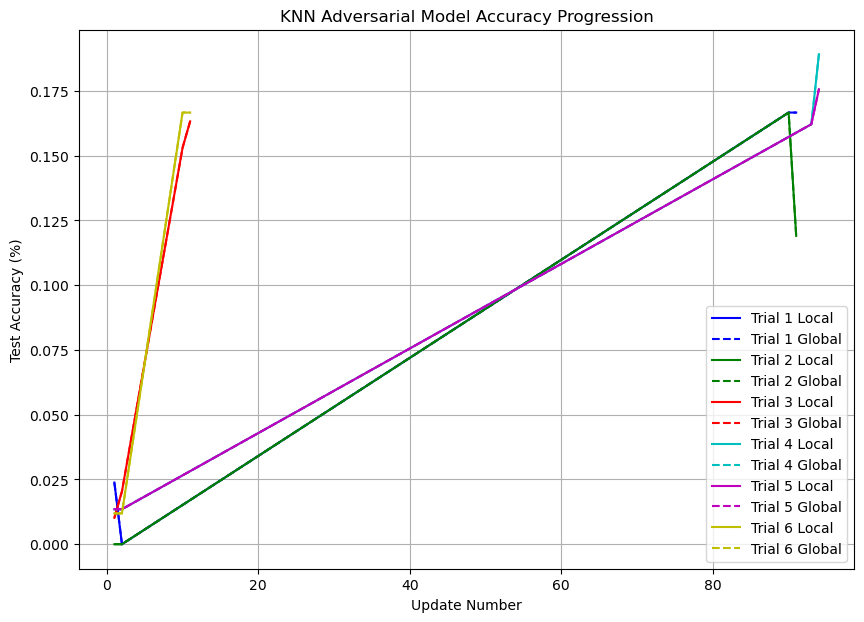

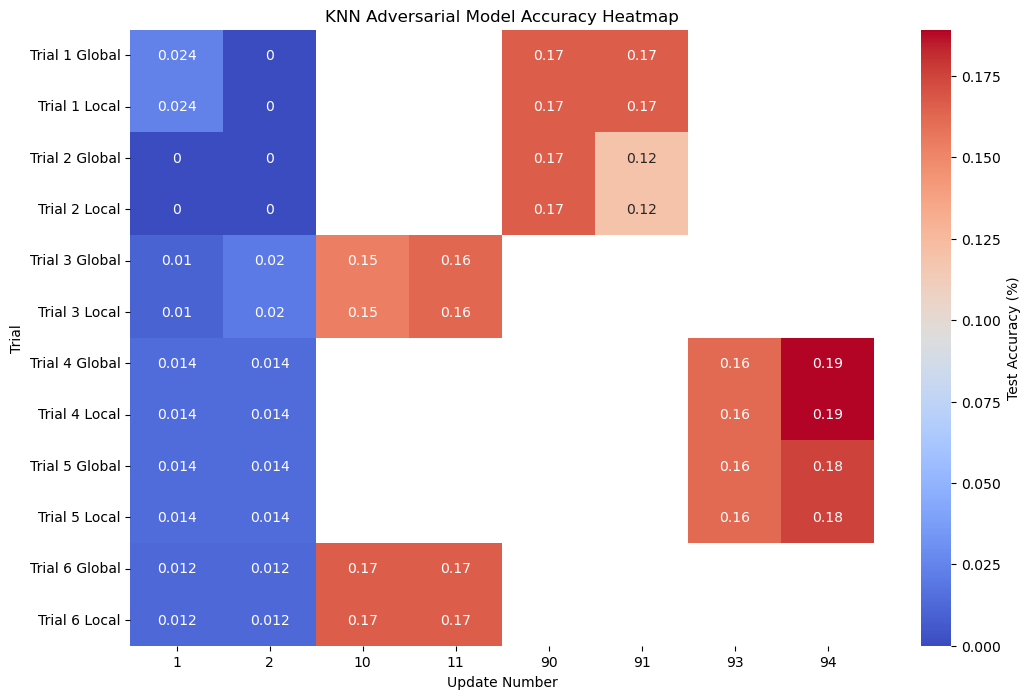

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# List of local and global dataframes
local_dfs = [ipfa_local_res_df, ifa_local_res_df, inofl_local_res_df, cpfa_local_res_df, cfa_local_res_df, cnofl_local_res_df]
global_dfs = [ipfa_global_res_df, ifa_global_res_df, inofl_global_res_df, cpfa_global_res_df, cfa_global_res_df, cnofl_global_res_df]

# Combine all dataframes and filter by 'KNeighborsClassifier'
filtered_dfs = []
for local_df, global_df in zip(local_dfs, global_dfs):
    # Filter for KNeighborsClassifier in each dataframe
    local_filtered = local_df[local_df['Adversarial Model'] == 'KNeighborsClassifier']
    global_filtered = global_df[global_df['Adversarial Model'] == 'KNeighborsClassifier']
    
    # Append both filtered dataframes to a combined list
    filtered_dfs.append(local_filtered)
    filtered_dfs.append(global_filtered)

# Concatenate all filtered dataframes
combined_df = pd.concat(filtered_dfs)

### 1. LINE PLOT
plt.figure(figsize=(10, 7))

# Define unique colors for trials (6 trials, local and global)
colors = ['b', 'g', 'r', 'c', 'm', 'y']
line_styles = ['-', '--']  # Solid for local, dashed for global

# Plot the local and global models with different line styles
for idx, df in enumerate(local_dfs):
    local_filtered = df[df['Adversarial Model'] == 'KNeighborsClassifier']
    global_filtered = global_dfs[idx][global_dfs[idx]['Adversarial Model'] == 'KNeighborsClassifier']
    
    plt.plot(local_filtered['Update Number'], local_filtered['Test Acc'], color=colors[idx], linestyle=line_styles[0], label=f'Trial {idx+1} Local')
    plt.plot(global_filtered['Update Number'], global_filtered['Test Acc'], color=colors[idx], linestyle=line_styles[1], label=f'Trial {idx+1} Global')

plt.xlabel('Update Number')
plt.ylabel('Test Accuracy (%)')
plt.title('KNN Adversarial Model Accuracy Progression')
plt.grid(True)
plt.legend(loc='best')
plt.show()

### 2. HEATMAP

# To create a heatmap, we need a pivoted dataframe where rows represent trials (local and global) and columns are Update Number

# Add a column to represent the trial name
for idx, (local_df, global_df) in enumerate(zip(local_dfs, global_dfs)):
    local_dfs[idx]['Trial'] = f'Trial {idx+1} Local'
    global_dfs[idx]['Trial'] = f'Trial {idx+1} Global'

# Combine all dataframes again with the new 'Trial' column
heatmap_df = pd.concat(local_dfs + global_dfs)

# Filter for KNeighborsClassifier and pivot the dataframe
heatmap_df = heatmap_df[heatmap_df['Adversarial Model'] == 'KNeighborsClassifier']
heatmap_pivot = heatmap_df.pivot(index='Trial', columns='Update Number', values='Test Acc')

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_pivot, annot=True, cmap='coolwarm', cbar_kws={'label': 'Test Accuracy (%)'})
plt.title('KNN Adversarial Model Accuracy Heatmap')
plt.xlabel('Update Number')
plt.ylabel('Trial')
plt.show()
